This notebook outlines a process for loading timeseries data and outputting it in a MIDI file as CC values that can then be used to control whatever you would like in a DAW or another music creation environment.

# Example 1: CSV to MIDI

In the simplest case, we will load a csv file containing measurements of atmospheric CO2 levels and write it out as a single channel of MIDI CC without worrying too much about handling the actual dates.

In [1]:
import pandas as pd
import numpy as np
from midiutil import MIDIFile

In [2]:
co2 = pd.read_csv('data/co2_mm_mlo.csv',  # downloaded from https://gml.noaa.gov/ccgg/trends/data.html
            header=41, #skip the header lines
            names = ['year','month','decimal_date','average','deseasonalized','ndays','sdev','unc'])


In [3]:
co2

,year,month,decimal_date,average,deseasonalized,ndays,sdev,unc
0,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
1,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
2,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
3,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
4,1958,8,1958.6219,314.93,316.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
783,2023,7,2023.5417,421.83,421.45,21,0.48,0.20
784,2023,8,2023.6250,419.68,421.57,21,0.45,0.19
785,2023,9,2023.7083,418.51,421.95,18,0.30,0.14
786,2023,10,2023.7917,418.82,422.10,27,0.47,0.17


<Axes: >

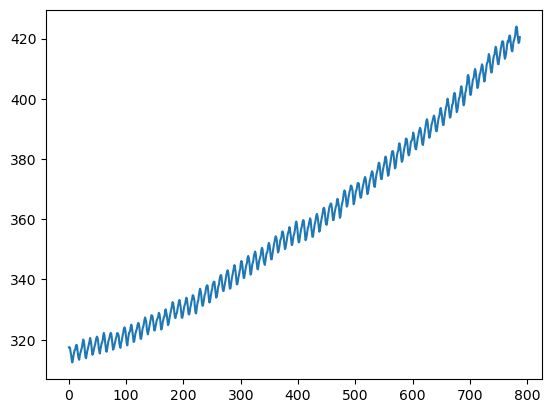

In [4]:
co2['average'].plot()

Before writing out to MIDI, we want to normalize the file to be in the range of 0-127 that are supported in a MIDI CC signal.

In [5]:
def norm_midi(cc,norm_bottom, norm_top):
    mmin = np.min(cc)
    cc = (cc - mmin)
    mmax = np.max(cc)
    cc = cc / mmax
    cc = cc * (norm_top - norm_bottom)
    cc = cc + norm_bottom
    return cc

In [6]:
co2

,year,month,decimal_date,average,deseasonalized,ndays,sdev,unc
0,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
1,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
2,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
3,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
4,1958,8,1958.6219,314.93,316.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
783,2023,7,2023.5417,421.83,421.45,21,0.48,0.20
784,2023,8,2023.6250,419.68,421.57,21,0.45,0.19
785,2023,9,2023.7083,418.51,421.95,18,0.30,0.14
786,2023,10,2023.7917,418.82,422.10,27,0.47,0.17


In [7]:
norm_bottom = 0
norm_top = 127
#cc = norm_midi(co2['average'], norm_bottom, norm_top)
co2['co2_normed'] = norm_midi(co2['average'], norm_bottom, norm_top)

<Axes: >

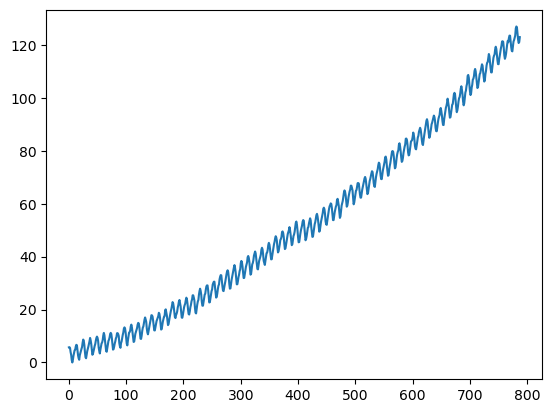

In [8]:
co2['co2_normed'].plot()

To write this data out as MIDI CC events, we use the MIDIUtil library, and specifically the addControllerEvent function.


Documentation can be found here:
https://midiutil.readthedocs.io/en/latest/class.html#midiutil.MidiFile.MIDIFile.addControllerEvent

In [9]:
mf = MIDIFile(1)      # make a new MIDIFile object with 1 track

mf.addTempo(track=0,  # add to the first track
           time=0,    # set the tempo starting at the beginning of the track
           tempo=80)  # set BPM

In [10]:
# need to decide how many beats each timestep in our data file should take
# with monthly data, if we want 1 year (12 timesteps) to last 1 bar (4 beats)
# each timestep should be 1/3 of a beat

tempo_mult = 0.333333

# iterate through each timestep in the file and write a value out to the MIDIFile object
for i, entry in enumerate(co2['co2_normed']):
    
        mf.addControllerEvent(track=0, 
                              channel=0,                 # 0-15
                              time=i*tempo_mult,         # time (in beats, as a float) to write value
                              controller_number=20,      # The CC channel to write to, 0-127
                              parameter=int(entry))      # value to write, must be integer
        
# save to a midi file
with open(f'data/manua_loa_co2_{norm_bottom}_{norm_top}_{tempo_mult}.mid', 'wb') as f:
    mf.writeFile(f)

This midi file now has data on the MIDI CC #20 channel that should be usable in your DAW if you import the midi file. Keep in mind there are no actual NOTES save in the midi file, so it may initially appear blank.

# Example 2: Load NetCDF and merge with CSV timeseries

Next we will load a climate timeseries from netcdf and merge it with the co2 timeseries from above. For this example I'm using a timeseries of northern hemisphere near-surface temperature extremes from the ERA5 reanalysis data product (a model reproduction of the historical climate).

If you want to learn to download your own timeseries of whatever climate data variable you would like, I highly recommend the method outlined in this tutorial: https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0


In [11]:
import xarray as xr

In [12]:
era5_temp = xr.open_dataset('data/era5_ts_nh.nc')

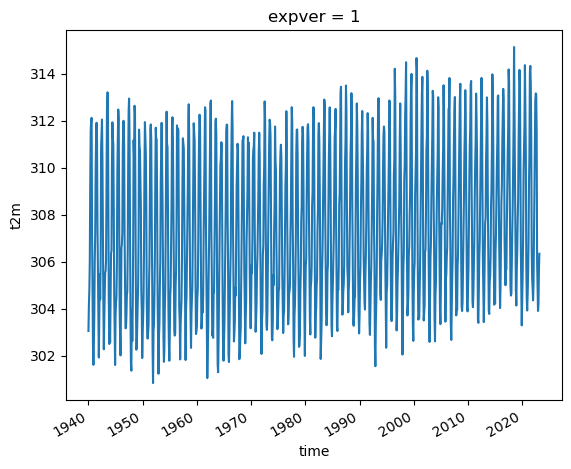

In [13]:
era5_temp.t2m.plot()

In [14]:
# normalize to acceptable midi values as above
era5_temp = norm_midi(era5_temp, norm_bottom, norm_top)

In [15]:
# convert to pandas and add 'year' and 'month' fields to match the c02 time series
era5_temp_df = era5_temp.to_pandas()
era5_temp_df['year'] = era5_temp_df.index.year
era5_temp_df['month'] = era5_temp_df.index.month

In [16]:
era5_temp_df

,expver,t2m,year,month
time,,,,
1940-01-01,1,19.652825,1940,1
1940-02-01,1,29.637563,1940,2
1940-03-01,1,34.922452,1940,3
1940-04-01,1,46.331295,1940,4
1940-05-01,1,75.066896,1940,5
...,...,...,...,...
2022-12-01,1,27.248057,2022,12
2023-01-01,1,29.922221,2023,1
2023-02-01,1,43.008381,2023,2


In [17]:
# merge the temperature dataset with the c02 dataset in a way that aligns their time-axis
merged_data_df = pd.merge(era5_temp_df, co2, on=['year','month'], how='left')

<Axes: >

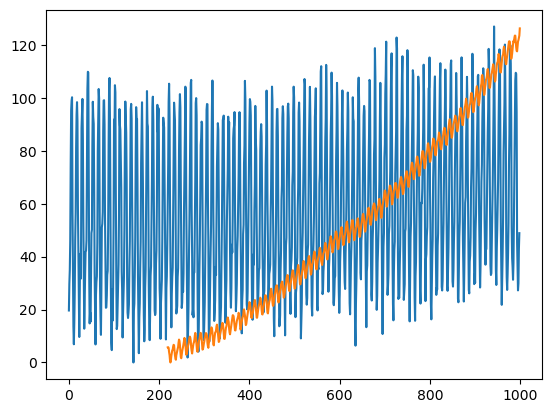

In [18]:
merged_data_df.t2m.plot()
merged_data_df.co2_normed.plot()

The data is merged onto a consistent time axis and normalized, but just note that they span different time ranges so we will have to be wary of that when iterating through to write out to MIDI

In [19]:
tempo_mult = 0.333333

mf = MIDIFile(1)
mf.addTempo(track=0, time=0, tempo=80)

for i in merged_data_df.index:
    t2m = merged_data_df.iloc[i].t2m

    co2 = merged_data_df.iloc[i].co2_normed
    
    # if we don't have a value for one of the fields, just write a zero
    if np.isnan(t2m):
        t2m=0
    if np.isnan(co2):
        co2=0

    # write co2 onto CC channel 20
    mf.addControllerEvent(track=0, channel=0, time=i*tempo_mult, controller_number=20, parameter=int(co2))
    
    #write temperature onto CC channel 21
    mf.addControllerEvent(track=0, channel=0, time=i*tempo_mult, controller_number=21, parameter=int(t2m))

with open(f'data/era5_t2m_co2_{tempo_mult}.mid', 'wb') as f:
    mf.writeFile(f)